In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm

from ex_simulation import p
from dset import get_dataloader, load_pretrained_model, generate_data
from sklearn import metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# load data
train_loader, test_loader = get_dataloader(p.data_path,
                                           batch_size=p.batch_size)

# import model
model = Feedforward(input_size=d).to(device)

# train model

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
num_epochs = 20

train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device)
        y = y.to(device)
        # zero grad
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(y, output)
        
        # backward
        loss.backward()
        # update step
        optimizer.step()          
        
        iter_loss = loss.item()   
        epoch_loss += iter_loss

        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), iter_loss), end='')              

    mean_epoch_loss = epoch_loss / (batch_idx + 1)
    train_losses.append(mean_epoch_loss)

# save model
torch.save(model.state_dict(), opj(p.model_path, 'FFN.pth')) 
    

Train Epoch: 19 [49900/50000 (100%)]	Loss: 0.016015

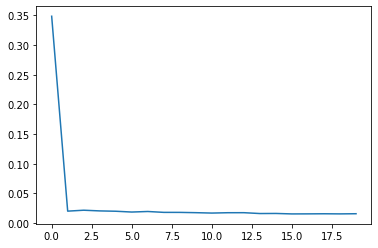

In [5]:
plt.plot(train_losses)

model prediction

R2-score: 0.9986337481425765


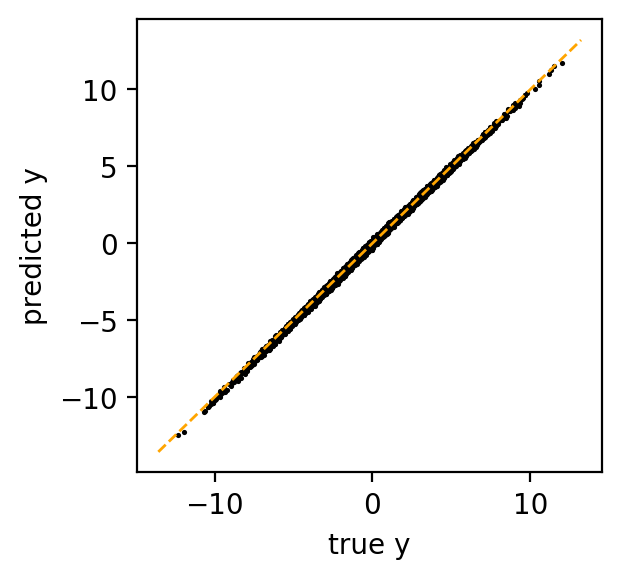

In [8]:
# check prediction
with torch.no_grad():
    result = {'y': [], 'pred': []}
    for data, y in test_loader:
        result['y'].append(y.squeeze().detach().cpu())
        result['pred'].append(model(data.to(device)).squeeze().detach().cpu())

y = torch.cat(result['y'])
pred = torch.cat(result['pred'])
print('R2-score:', metrics.r2_score(y.numpy(), pred.numpy()))

fig = plt.figure(dpi=200, figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.scatter(y, pred,
           marker=".", 
           alpha=1, 
           zorder=0, 
           color="black",
           s=3)
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, zorder=2, color="orange", linestyle='--', linewidth=1)
ax.set_xlabel("true y")
ax.set_ylabel("predicted y")
plt.show()